## Aircraft Engine Failure Prediction

This file includes steps to build a LSTM Model. Since any deep learning models require many hyperparameters, finding out the perfect architecture is very important. While there is no specific method for model architecture, We can rely on some rule of thumbs.

I follow tips suggested in this article: https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af

### Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("../Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

2022-11-25 22:07:58.115048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 22:07:58.262073: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 22:07:58.741413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tomxu/miniconda3/envs/tf/lib/
2022-11-25 22:07:58.741500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    return df_train, df_test, y_true

In [3]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [4]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [5]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [6]:
# both the trainset and holdout set label are set to classify next 50 cycles 
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [7]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [8]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [9]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [10]:
def gen_train(id_df, seq_length, seq_cols):
    """
        prepare train data into (samples, time steps, features) by moving window overlay
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [11]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [12]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [13]:
sequence_length = 50 #predicting using last 50 cycle values
mask_value = 0


Let's prepare data using above functions.

In [14]:
#generate train, look back is always agianst each unit's time series, get_train will reduce each unit's rows by 49
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [15]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [16]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features, nb_out

(15, 1)

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1
cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print Results

In [58]:
def print_results(y_test, y_pred):    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Model with 1 hidden layer

#### Model 1

In [28]:
history = History()
model1 = Sequential()
model1.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model1.add(Dense(units=nb_out, activation='sigmoid'))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
# fit the model
model1.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, 
           class_weight=cls_wt, callbacks=[history])

Epoch 1/100
222/222 [==============================] - 4s 12ms/step - loss: 0.2237 - accuracy: 0.8493 - val_loss: 0.3460 - val_accuracy: 0.8856
Epoch 2/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1378 - accuracy: 0.8983 - val_loss: 0.2850 - val_accuracy: 0.9015
Epoch 3/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1117 - accuracy: 0.9176 - val_loss: 0.2423 - val_accuracy: 0.9155
Epoch 4/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0979 - accuracy: 0.9268 - val_loss: 0.2269 - val_accuracy: 0.9295
Epoch 5/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0882 - accuracy: 0.9305 - val_loss: 0.2029 - val_accuracy: 0.9320
Epoch 6/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0792 - accuracy: 0.9325 - val_loss: 0.1983 - val_accuracy: 0.9352
Epoch 7/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0738 - accuracy: 0.9361 - val_loss: 0.1948 - val_accuracy:

Text(0.5, 1.0, 'Loss')

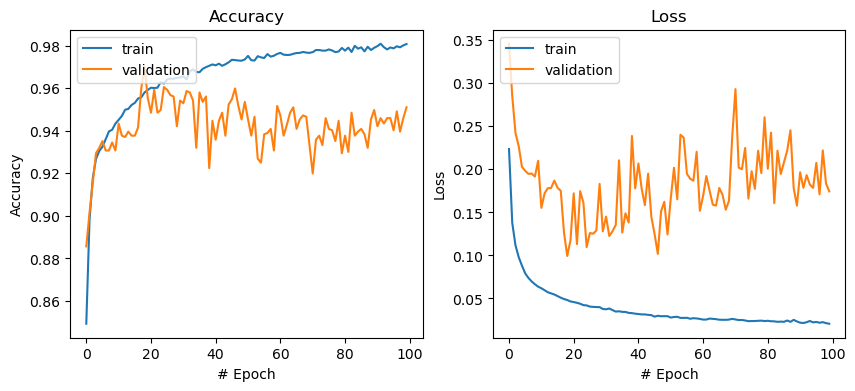

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 8ms/step
F1 Score:  0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.94      1.00      0.97        30

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9857142857142857 



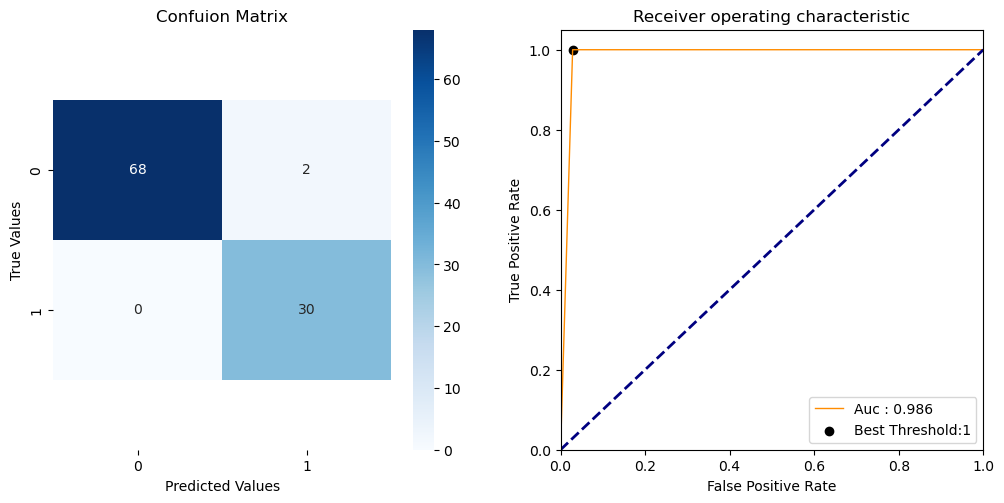

In [59]:
y_pred = (model1.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [60]:
confusion_matrix(y_train, (model1.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 2s 3ms/step


array([[10527,   204],
       [  200,  4800]])

Even though we get very good results, there is an overfitting which can be seen in the Loss graph. After 25 epochs, the loss of validation set is increasing and loss of training set keeps on decreasing. Also, the accuracy of validation set remains constant after 25 epochs.

#### Model 2

Model 2 is same as Model 1 but the early stopping is implemented to stop overfitting. 

In [34]:
history = History()
model2 = Sequential()
model2.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=nb_out, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight=cls_wt,
           callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 4s 13ms/step - loss: 0.1894 - accuracy: 0.8779 - val_loss: 0.3263 - val_accuracy: 0.8793
Epoch 2/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1350 - accuracy: 0.8917 - val_loss: 0.2870 - val_accuracy: 0.8831
Epoch 3/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1144 - accuracy: 0.9093 - val_loss: 0.2314 - val_accuracy: 0.9180
Epoch 4/100
222/222 [==============================] - 2s 9ms/step - loss: 0.0976 - accuracy: 0.9246 - val_loss: 0.2192 - val_accuracy: 0.9257
Epoch 5/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0903 - accuracy: 0.9309 - val_loss: 0.2330 - val_accuracy: 0.9142
Epoch 6/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0864 - accuracy: 0.9298 - val_loss: 0.2050 - val_accuracy: 0.9212
Epoch 7/100
222/222 [==============================] - 2s 10ms/step - loss: 0.0822 - accuracy: 0.9320 - val_loss: 0.1845 - val_accuracy: 

Text(0.5, 1.0, 'Loss')

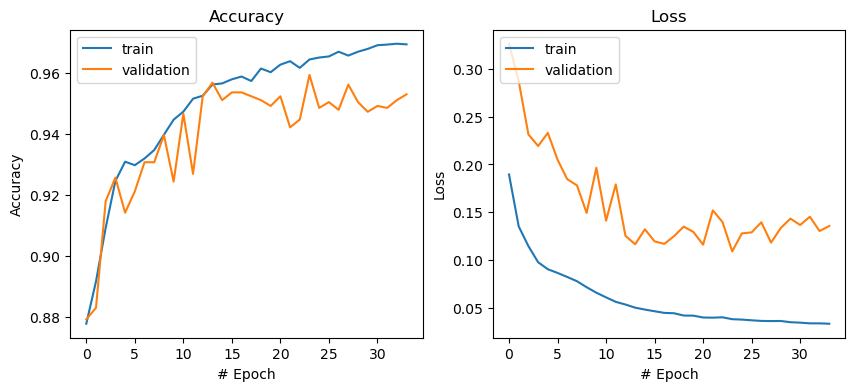

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 9ms/step
F1 Score:  0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.88      1.00      0.94        30

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9714285714285714 



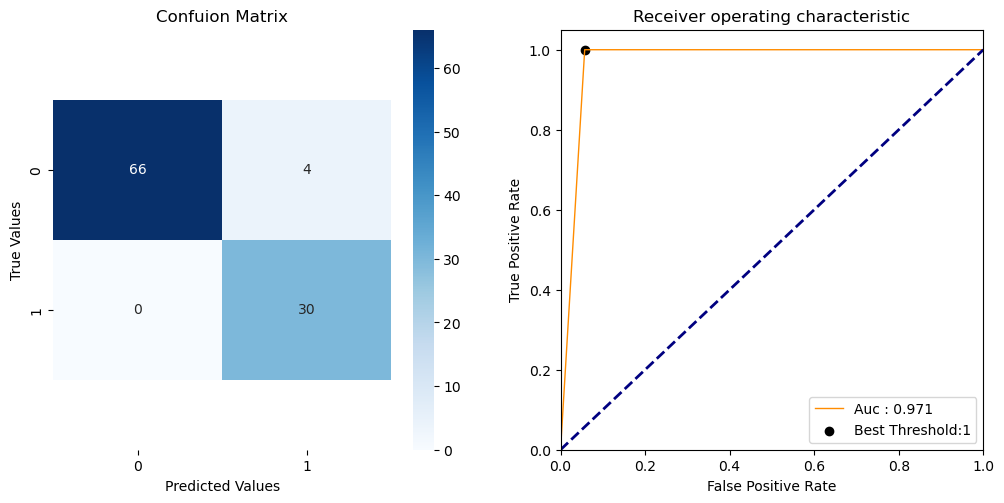

In [37]:
y_pred = (model2.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [38]:
confusion_matrix(y_train, (model2.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 2s 3ms/step


array([[10418,   313],
       [  156,  4844]])

#### Model 3

Model 3 is same as Model 2 but dropout is added to further reduce overfitting. 

In [39]:
history = History()
model3 = Sequential()
model3.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model3.add(Dropout(0.25))
model3.add(Dense(units=nb_out, activation='sigmoid'))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4)                 320       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time
# fit the model
model3.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 4s 13ms/step - loss: 0.2554 - accuracy: 0.6441 - val_loss: 0.4183 - val_accuracy: 0.8774
Epoch 2/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1620 - accuracy: 0.8864 - val_loss: 0.3220 - val_accuracy: 0.8710
Epoch 3/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1347 - accuracy: 0.8914 - val_loss: 0.2846 - val_accuracy: 0.8736
Epoch 4/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1225 - accuracy: 0.8947 - val_loss: 0.2567 - val_accuracy: 0.8736
Epoch 5/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1150 - accuracy: 0.9020 - val_loss: 0.3171 - val_accuracy: 0.8672
Epoch 6/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1132 - accuracy: 0.9073 - val_loss: 0.2212 - val_accuracy: 0.8888
Epoch 7/100
222/222 [==============================] - 2s 10ms/step - loss: 0.1081 - accuracy: 0.9102 - val_loss: 0.2213 - val_accuracy:

Text(0.5, 1.0, 'Loss')

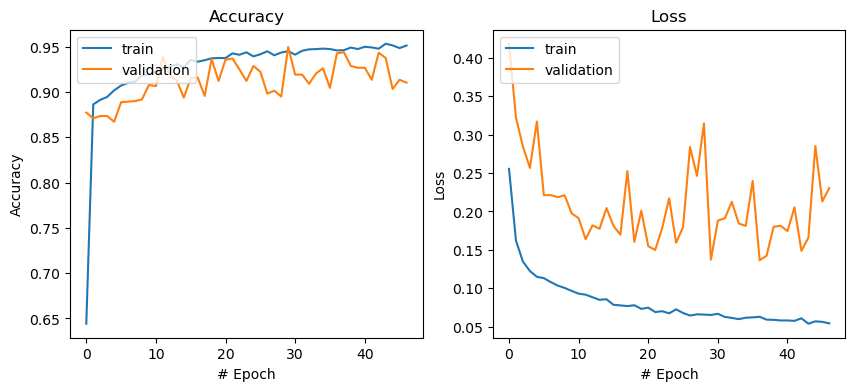

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 8ms/step
F1 Score:  0.9354838709677419
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.91      0.97      0.94        30

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9619047619047619 



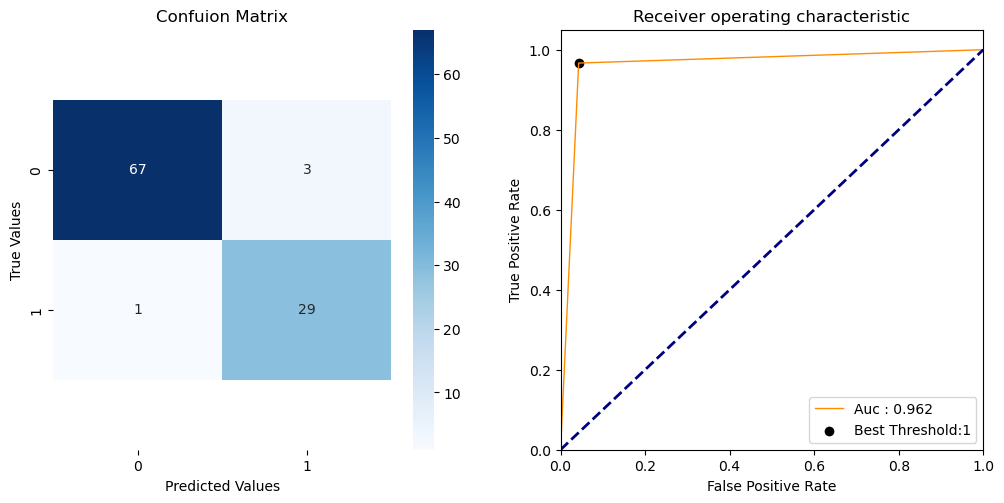

In [42]:
y_pred = (model3.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [43]:
confusion_matrix(y_train, (model3.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 2s 3ms/step


array([[10213,   518],
       [  202,  4798]])

#### Model 4

Model 4 has two hidden layers to learn complex patterns in the data.

In [44]:
history = History()
model4 = Sequential()
model4.add(LSTM(units=8, return_sequences=True, input_shape=(sequence_length, nb_features)))
model4.add(Dropout(0.2))
model4.add(LSTM(units=4, return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=nb_out, activation='sigmoid'))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 8)             768       
                                                                 
 dropout_1 (Dropout)         (None, 50, 8)             0         
                                                                 
 lstm_7 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [45]:
%%time
# fit the model
model4.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100
222/222 [==============================] - 6s 19ms/step - loss: 0.1982 - accuracy: 0.8419 - val_loss: 0.3219 - val_accuracy: 0.8704
Epoch 2/100
222/222 [==============================] - 3s 15ms/step - loss: 0.1309 - accuracy: 0.8997 - val_loss: 0.2683 - val_accuracy: 0.8888
Epoch 3/100
222/222 [==============================] - 3s 15ms/step - loss: 0.1039 - accuracy: 0.9212 - val_loss: 0.2239 - val_accuracy: 0.9053
Epoch 4/100
222/222 [==============================] - 3s 15ms/step - loss: 0.0897 - accuracy: 0.9281 - val_loss: 0.1621 - val_accuracy: 0.9352
Epoch 5/100
222/222 [==============================] - 3s 15ms/step - loss: 0.0832 - accuracy: 0.9328 - val_loss: 0.1840 - val_accuracy: 0.9199
Epoch 6/100
222/222 [==============================] - 3s 14ms/step - loss: 0.0752 - accuracy: 0.9397 - val_loss: 0.1549 - val_accuracy: 0.9441
Epoch 7/100
222/222 [==============================] - 3s 15ms/step - loss: 0.0704 - accuracy: 0.9431 - val_loss: 0.1074 - val_accuracy:

Text(0.5, 1.0, 'Loss')

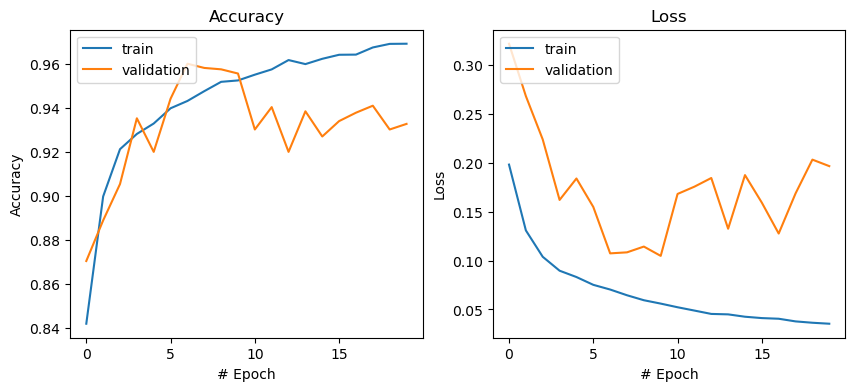

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 1s 14ms/step
F1 Score:  0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.91      1.00      0.95        30

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

Area under curve :  0.9785714285714286 



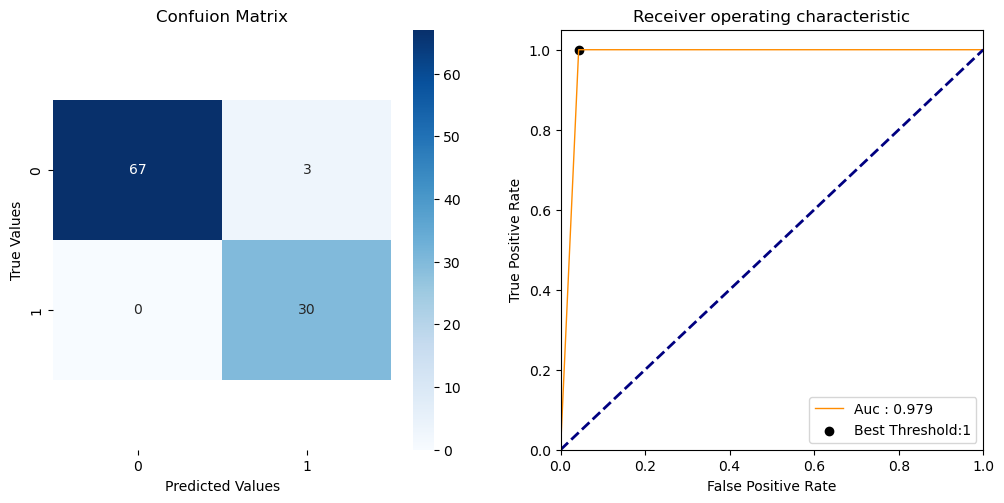

In [47]:
y_pred = (model4.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [48]:
confusion_matrix(y_train, (model4.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 2s 5ms/step


array([[10422,   309],
       [  145,  4855]])

#### False Positives Analysis

In [49]:
y_true['pred'] = y_pred
y_true.head()

,RUL,UnitNumber,failure,pred
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0


In [50]:
y_true[y_true.failure != y_true.pred]

,RUL,UnitNumber,failure,pred
16,50,16,0,1
61,54,61,0,1
83,58,83,0,1


The RUL for False positives is near to 50 cycles only.

### Experiment

LSTM models have stochasticity and the results might be different everytime. I run the model (architecture same as mdoel 4) 10 times and check the performance of model.

In [63]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """    
    score_list = []
    for i in range(0, nruns):
        start = time.time()
        model = Sequential()
        model.add(LSTM(units=8, return_sequences=True, input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=4, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])
        model.fit(X, y, epochs=100, batch_size=64, validation_split=0.1, verbose=0, class_weight=cls_wt,
                  shuffle=True, callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                   verbose=0, mode='auto')])
        predictions = (model.predict(x_test) > 0.5).astype("int32")
        acc = accuracy_score(y_test, predictions)
        pr = precision_score(y_test, predictions)
        rc = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)
        score_list.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr,
                           'Recall': rc, 'F1 Score': f1, 'AUC Score': auc})
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")
    score_df = pd.DataFrame(score_list, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC Score"])
    return score_df

In [64]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns=10)

4/4 [==============================] - 0s 5ms/step
Run:1 and Runtime:54.793 Seconds
4/4 [==============================] - 0s 6ms/step
Run:2 and Runtime:51.726 Seconds
4/4 [==============================] - 0s 5ms/step
Run:3 and Runtime:64.778 Seconds
4/4 [==============================] - 0s 5ms/step
Run:4 and Runtime:98.829 Seconds
4/4 [==============================] - 0s 5ms/step
Run:5 and Runtime:59.071 Seconds
4/4 [==============================] - 0s 6ms/step
Run:6 and Runtime:62.641 Seconds
4/4 [==============================] - 0s 5ms/step
Run:7 and Runtime:67.925 Seconds
4/4 [==============================] - 0s 5ms/step
Run:8 and Runtime:73.264 Seconds
4/4 [==============================] - 0s 5ms/step
Run:9 and Runtime:57.135 Seconds
4/4 [==============================] - 0s 5ms/step
Run:10 and Runtime:55.327 Seconds


In [65]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC Score
0,1,0.95,0.878788,0.966667,0.920635,0.954762
1,2,0.97,0.909091,1.000000,0.952381,0.978571
2,3,0.99,0.967742,1.000000,0.983607,0.992857
3,4,0.98,0.937500,1.000000,0.967742,0.985714
4,5,0.94,0.852941,0.966667,0.906250,0.947619
5,6,0.96,0.882353,1.000000,0.937500,0.971429
6,7,0.97,0.909091,1.000000,0.952381,0.978571
7,8,0.99,0.967742,1.000000,0.983607,0.992857
8,9,0.97,0.909091,1.000000,0.952381,0.978571
9,10,0.94,0.833333,1.000000,0.909091,0.957143


Text(0, 0.5, 'Value')

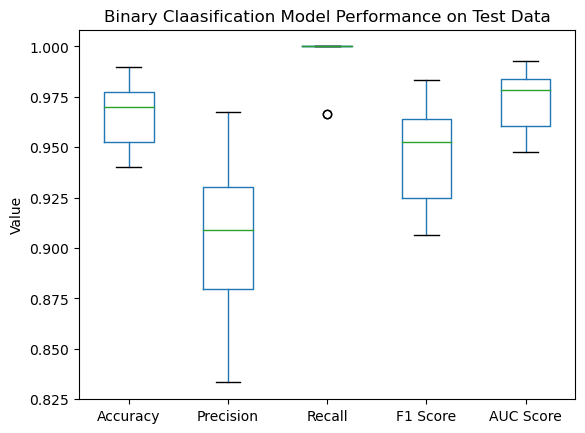

In [66]:
fig, ax = plt.subplots()
result_df.drop(['Model'], axis=1).boxplot(vert=1, ax=ax)
ax.set_title('Binary Claasification Model Performance on Test Data')
ax.grid(visible=None)
ax.set_ylabel('Value')

In [67]:
result_df.mean()

Model        5.500000
Accuracy     0.966000
Precision    0.904767
Recall       0.993333
F1 Score     0.946557
AUC Score    0.973810
dtype: float64